In [2]:
pip install pandas numpy seaborn matplotlib scikit-learn tensorflow pillow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from scipy import stats
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set matplotlib to display plots inline
plt.ion()  # Interactive mode for plots in VS Code

In [4]:
# Hardcode the full path to the CSV file (adjust based on your local file system)
csv_path = "D:\\archive\\HAM10000_metadata.csv"  # Update this path
if not csv_path.endswith('.csv'):
    raise ValueError("Please ensure the path points to a valid .csv file (HAM10000_metadata.csv)")
metadata = pd.read_csv(csv_path)
print("Metadata loaded successfully. Shape:", metadata.shape)

# Add placeholder for image paths
metadata['image_path'] = ''

Metadata loaded successfully. Shape: (10015, 7)


In [5]:
# Hardcode the full path to the image folder (adjust based on your local file system)
image_folder_path = r"D:\archive"  # Use raw string or "D:\\archive" for Windows paths
dataset_path = image_folder_path

# Define image directories
image_dir_part1 = os.path.join(dataset_path, 'ham10000_images_part_1')
image_dir_part2 = os.path.join(dataset_path, 'ham10000_images_part_2')

# Verify directories exist
if not (os.path.exists(image_dir_part1) and os.path.exists(image_dir_part2)):
    raise ValueError(f"Image directories not found. Check that {image_dir_part1} and {image_dir_part2} exist. Ensure the path {image_folder_path} contains the correct subdirectories.")

# Update image paths in metadata
def get_image_path(image_id):
    path1 = os.path.join(image_dir_part1, f"{image_id}.jpg")
    path2 = os.path.join(image_dir_part2, f"{image_id}.jpg")
    return path1 if os.path.exists(path1) else path2

# Ensure metadata is defined (add this check or load it beforehand)
if 'metadata' not in globals():
    raise NameError("Metadata is not defined. Please load the CSV file containing 'image_id' first.")

metadata['image_path'] = metadata['image_id'].apply(get_image_path)
print("Image paths assigned successfully.")

Image paths assigned successfully.


In [7]:
# Data Cleansing and Removal Steps

# 1. Remove 'vasc' and 'df' classes
classes_to_remove = ['vasc', 'df']
cleaned_df = metadata[~metadata['dx'].isin(classes_to_remove)]
print("\nDataset shape after removing 'vasc' and 'df' classes:", cleaned_df.shape)

# 2. Subsample 'nv' class to 1000 images
nv_class = cleaned_df[cleaned_df['dx'] == 'nv']
other_classes = cleaned_df[cleaned_df['dx'] != 'nv']
nv_sampled = nv_class.sample(n=1000, random_state=42)
print("\nShape of sampled 'nv' class:", nv_sampled.shape)

# 3. Create the new balanced dataframe
balanced_df = pd.concat([nv_sampled, other_classes], ignore_index=True)
print("\nShape of balanced dataframe:", balanced_df.shape)

# 4. Check the result
print("\nFinal balanced distribution:")
print(balanced_df['dx'].value_counts())

# 5. Check for missing values in the balanced dataset
print("\nMissing values in balanced dataset:")
print(balanced_df.isnull().sum())

# 6. Handle missing values - drop rows with missing 'age' (clinical dataset caution)
balanced_df_cleaned = balanced_df.dropna(subset=['age'])
print(f"\nOriginal balanced shape: {balanced_df.shape}")
print(f"After removing missing age: {balanced_df_cleaned.shape}")

# 7. Save the cleaned and balanced dataframe to a CSV file
balanced_df_cleaned.to_csv('cleaned_balanced_skin_cancer_data.csv', index=False)
print("Cleaned and balanced dataset saved successfully!")


Dataset shape after removing 'vasc' and 'df' classes: (9758, 8)

Shape of sampled 'nv' class: (1000, 8)

Shape of balanced dataframe: (4053, 8)

Final balanced distribution:
dx
mel      1113
bkl      1099
nv       1000
bcc       514
akiec     327
Name: count, dtype: int64

Missing values in balanced dataset:
lesion_id        0
image_id         0
dx               0
dx_type          0
age             20
sex              0
localization     0
image_path       0
dtype: int64

Original balanced shape: (4053, 8)
After removing missing age: (4033, 8)
Cleaned and balanced dataset saved successfully!


In [10]:
# Load the cleaned and balanced dataset
cleaned_csv_path = 'cleaned_balanced_skin_cancer_data.csv'
if not os.path.exists(cleaned_csv_path):
    raise FileNotFoundError(f"Cleaned CSV file not found at {cleaned_csv_path}. Please ensure it was saved previously.")
cleaned_metadata = pd.read_csv(cleaned_csv_path)
print("Cleaned metadata loaded successfully. Shape:", cleaned_metadata.shape)

# Add placeholder for image paths in cleaned metadata
cleaned_metadata['image_path'] = ''

# Update image paths in cleaned metadata
def get_image_path(image_id):
    path1 = os.path.join(image_dir_part1, f"{image_id}.jpg")
    path2 = os.path.join(image_dir_part2, f"{image_id}.jpg")
    if os.path.exists(path1):
        return path1
    elif os.path.exists(path2):
        return path2
    else:
        print(f"Warning: Image {image_id}.jpg not found in either directory.")
        return None

cleaned_metadata['image_path'] = cleaned_metadata['image_id'].apply(get_image_path)
print("Image paths assigned successfully for cleaned dataset. Checking for missing images...")

# Count and report images that weren't found in the cleaned dataset
missing_images = cleaned_metadata['image_path'].isna().sum()
print(f"Number of images not found in cleaned dataset: {missing_images}")
if missing_images > 0:
    print("Consider reviewing the dataset or image directories for missing files.")

# Categorize images into separate folders based on dx
output_base_dir = os.path.join(dataset_path, 'categorized_images')
os.makedirs(output_base_dir, exist_ok=True)

categories = {'mel': 1113, 'bkl': 1099, 'nv': 1000, 'bcc': 514, 'akiec': 327}
for category, count in categories.items():
    category_dir = os.path.join(output_base_dir, category)
    os.makedirs(category_dir, exist_ok=True)
    category_data = cleaned_metadata[cleaned_metadata['dx'] == category]
    if len(category_data) != count:
        print(f"Warning: Expected {count} images for {category}, found {len(category_data)}.")
    for index, row in category_data.iterrows():
        if pd.notna(row['image_path']):
            destination = os.path.join(category_dir, f"{row['image_id']}.jpg")
    print(f"Copied {len(category_data)} images to {category_dir}")

# Save the cleaned metadata with updated image paths
cleaned_metadata.to_csv('cleaned_metadata_with_image_paths.csv', index=False)
print("Cleaned metadata with image paths saved successfully for exploration!")

Cleaned metadata loaded successfully. Shape: (4033, 8)
Image paths assigned successfully for cleaned dataset. Checking for missing images...
Number of images not found in cleaned dataset: 0
Copied 1111 images to D:\archive\categorized_images\mel
Copied 1089 images to D:\archive\categorized_images\bkl
Copied 992 images to D:\archive\categorized_images\nv
Copied 514 images to D:\archive\categorized_images\bcc
Copied 327 images to D:\archive\categorized_images\akiec
Cleaned metadata with image paths saved successfully for exploration!


In [3]:
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#Load the dataset
df = pd.read_csv('D:\\SLIIT\\Y2S1\\AI & ML\\Project\\2025-Y2-S1-MLB-B9G2-05\\result\\outputs\\cleaned_metadata_with_image_paths.csv')


In [8]:
# Member 1: Himandi A.H.S. - Handling Missing Data
# Check for missing values
print("Missing values per column:\n", df.isnull().sum())

# Drop rows with any missing values
df = df.dropna()

# Verify no missing values remain
print("Missing values after dropping:\n", df.isnull().sum())


Missing values per column:
 lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
image_path      0
dtype: int64
Missing values after dropping:
 lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
image_path      0
dtype: int64


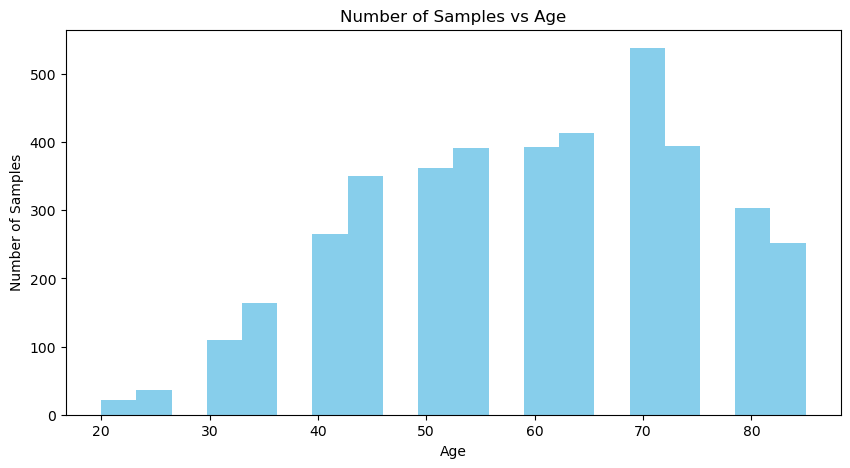

In [9]:
# Create a histogram for 'age'
plt.figure(figsize=(10, 5))
plt.title("Number of Samples vs Age")
plt.hist(df['age'].dropna(), bins=20, color='skyblue')
plt.xlabel("Age")
plt.ylabel("Number of Samples")
plt.show()

In [4]:

# Member 2: Weerathunga B.A. - Encoding Categorical Variables

# Encode target 'dx'
label_encoder = LabelEncoder()
df['dx_encoded'] = label_encoder.fit_transform(df['dx'])
print("\nEncoded target 'dx':", df[['dx', 'dx_encoded']].head())
print("\nLabel mapping for 'dx':", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# One-hot encode categorical columns
df_encoded = pd.get_dummies(df, columns=['dx_type', 'sex', 'localization'], drop_first=True)

# Fill missing 'age' with mean
if df_encoded['age'].isnull().sum() > 0:
    df_encoded['age'].fillna(df_encoded['age'].mean(), inplace=True)

# Drop unnecessary columns
df_encoded.drop(['lesion_id', 'image_id', 'image_path', 'dx'], axis=1, inplace=True)

# Display info and first 5 rows
print("\nPreprocessed DataFrame Info:", df_encoded.info())
print("\nFirst 5 rows of preprocessed DataFrame:", df_encoded.head())   




Encoded target 'dx':    dx  dx_encoded
0  nv           4
1  nv           4
2  nv           4
3  nv           4
4  nv           4

Label mapping for 'dx': {'akiec': np.int64(0), 'bcc': np.int64(1), 'bkl': np.int64(2), 'mel': np.int64(3), 'nv': np.int64(4)}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4033 entries, 0 to 4032
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           4033 non-null   float64
 1   dx_encoded                    4033 non-null   int64  
 2   dx_type_consensus             4033 non-null   bool   
 3   dx_type_follow_up             4033 non-null   bool   
 4   dx_type_histo                 4033 non-null   bool   
 5   sex_male                      4033 non-null   bool   
 6   sex_unknown                   4033 non-null   bool   
 7   localization_back             4033 non-null   bool   
 8   localization_chest            4033 non-nu

C:\Users\weera\AppData\Local\Temp\ipykernel_4648\2353920016.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='localization', data=df, palette='pastel')


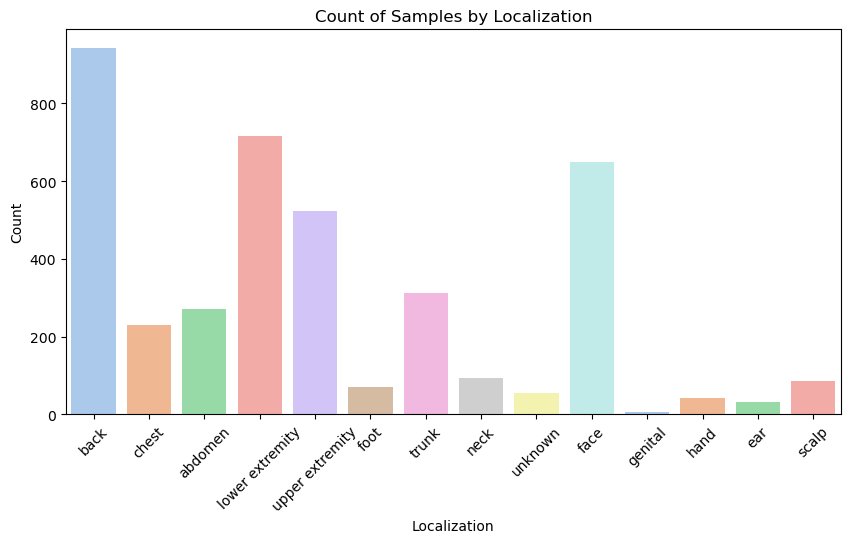

In [5]:
# count plot for 'localization'
plt.figure(figsize=(10, 5))  # Slightly wider for more categories
sns.countplot(x='localization', data=df, palette='pastel')
plt.title("Count of Samples by Localization")
plt.xlabel("Localization")
plt.ylabel("Count")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [12]:

# Member 3: Modarage K.R. - Outlier Removal
# Calculate Q1, Q3, and IQR for 'age'
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df = df[(df['age'] >= lower_bound) & (df['age'] <= upper_bound)]

# Display the shape after outlier removal
print("Shape after outlier removal:", df.shape)


Shape after outlier removal: (3995, 8)


C:\Users\weera\AppData\Local\Temp\ipykernel_13568\3329747110.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=df['age'], palette='pastel')


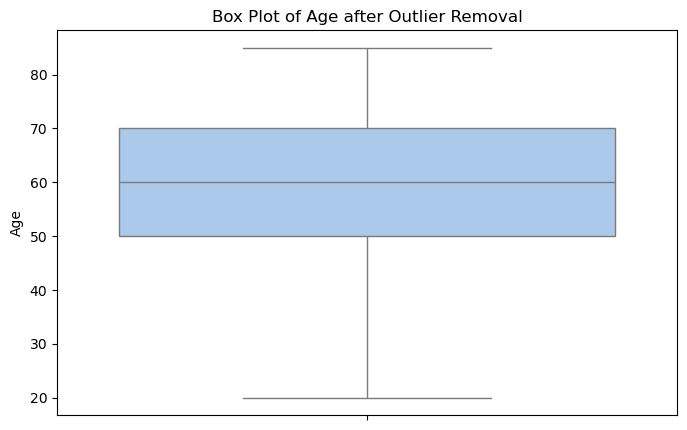

In [13]:
# Remove outliers using IQR method
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['age'] >= lower_bound) & (df['age'] <= upper_bound)]

# Create a box plot for 'age'
plt.figure(figsize=(8, 5))
sns.boxplot(y=df['age'], palette='pastel')
plt.title("Box Plot of Age after Outlier Removal")
plt.ylabel("Age")
plt.show()

In [6]:

# Member 4:Delpachithra K.N- Normalization_Scaling 
# Keep original 'age' before scaling
df['age_raw'] = df['age']

# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform only once → create a new column
df['age_normalized'] = scaler.fit_transform(df[['age_raw']])

# Display the first few rows
print(df[['age_raw', 'age_normalized']].head())

   age_raw  age_normalized
0     40.0        0.470588
1     40.0        0.470588
2     35.0        0.411765
3     40.0        0.470588
4     40.0        0.470588


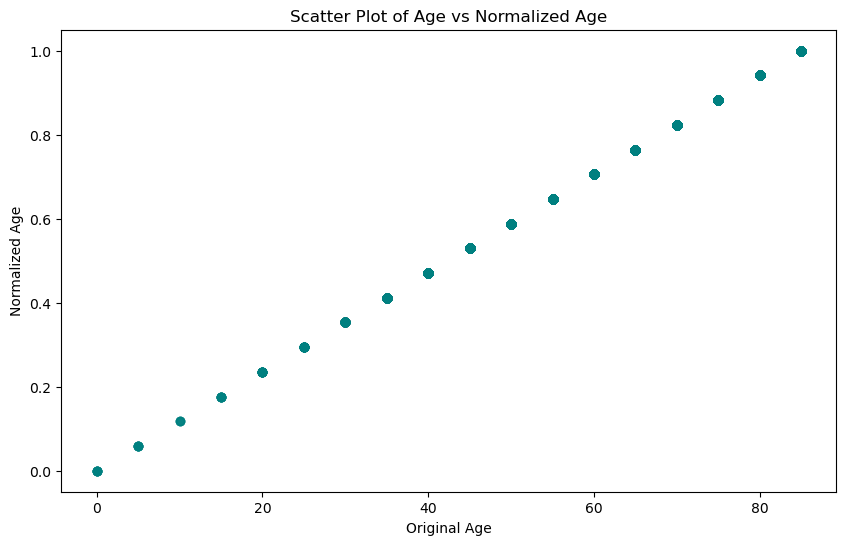

In [7]:
# Normalize 'age'
scaler = MinMaxScaler()
df['age_normalized'] = scaler.fit_transform(df[['age']])

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['age'], df['age_normalized'], color='teal', alpha=0.5)
plt.title("Scatter Plot of Age vs Normalized Age")
plt.xlabel("Original Age")
plt.ylabel("Normalized Age")
plt.show()

In [ ]:
#Member 5
# Separate features and target
X = df[['age', 'sex']]
y = df['dx']

# Convert 'sex' to numerical for feature selection
X = pd.get_dummies(X)

# Apply SelectKBest
selector = SelectKBest(score_func=f_classif, k=2)
selector.fit(X, y)

# Get selected feature scores
print("Feature scores:", selector.scores_)

Feature scores: [279.61229255   8.13250792   8.39016917   1.53395447]


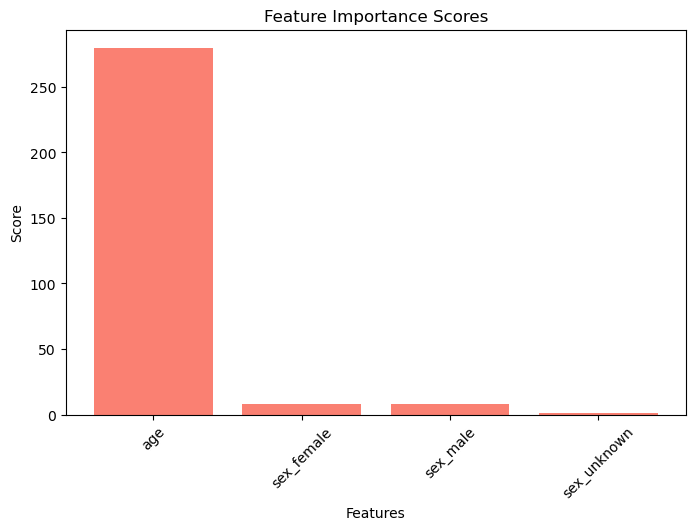

In [20]:
# Prepare features and target
X = pd.get_dummies(df[['age', 'sex']])
y = df['dx']

# Apply SelectKBest
selector = SelectKBest(score_func=f_classif, k=2)
selector.fit(X, y)

# Create a bar graph of feature importance
plt.figure(figsize=(8, 5))
plt.bar(X.columns, selector.scores_, color='salmon')
plt.title("Feature Importance Scores")
plt.xlabel("Features")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()

In [ ]:
#Member 6
# Prepare features
X = pd.get_dummies(df[['age', 'sex', 'localization']])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Display the shape of transformed data
print("Shape after PCA:", X_pca.shape)

Shape after PCA: (4033, 2)


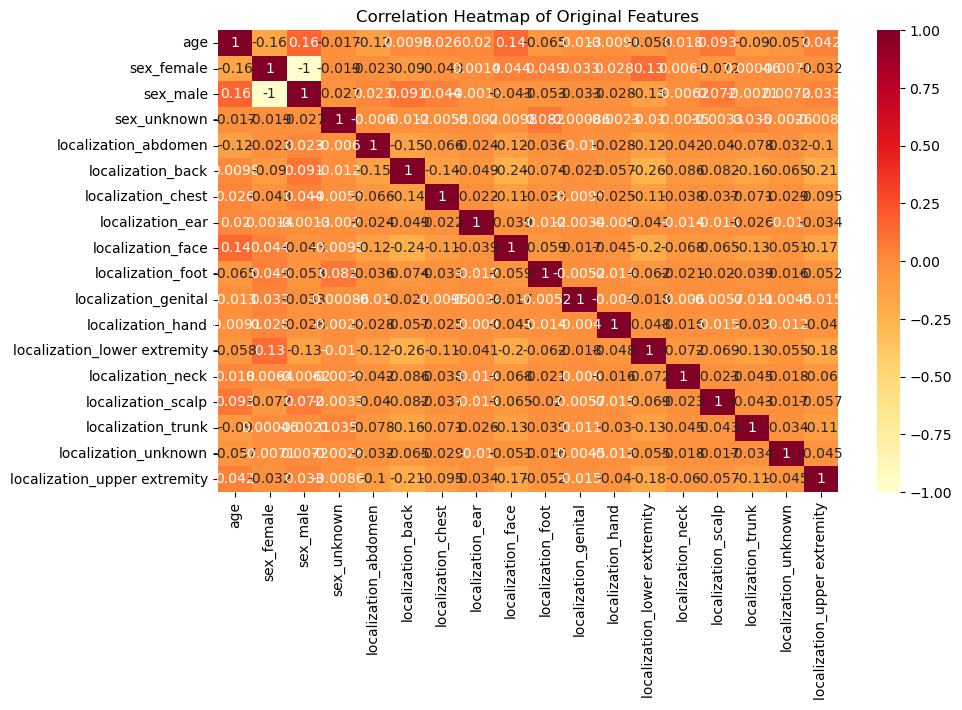

In [23]:
# Prepare features
X = pd.get_dummies(df[['age', 'sex', 'localization']])

# Standardize and apply PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a correlation heatmap of the original features
plt.figure(figsize=(10, 6))
sns.heatmap(X.corr(), annot=True, cmap="YlOrRd", vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Original Features")
plt.show()

In [ ]:

#Intigrated group Pipline

# Member 1: Handling Missing Data
print("Missing values per column:\n", df.isnull().sum())
df = df.dropna()
print("Missing values after dropping:\n", df.isnull().sum())

# Member 3: Outlier Removal
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['age'] >= lower_bound) & (df['age'] <= upper_bound)]

# Member 2: Encoding Categorical Data
df_encoded = pd.get_dummies(df, columns=['sex', 'localization'])

# Member 4: Normalization/Scaling
scaler = MinMaxScaler()
df_encoded['age'] = scaler.fit_transform(df_encoded[['age']])

# Member 5: Feature Selection
X = df_encoded[['age'] + list(df_encoded.filter(like='sex_')) + list(df_encoded.filter(like='localization_'))]
y = df_encoded['dx']
selector = SelectKBest(score_func=f_classif, k=5)
selector.fit(X, y)
selected_features = X.columns[selector.get_support()].tolist()
print("Selected features:", selected_features)

# Member 6: Dimension Reduction
X_selected = df_encoded[selected_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print("Shape after PCA:", X_pca.shape)

# Final preprocessed dataset
final_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
final_df = pd.concat([final_df, df_encoded[selected_features]], axis=1)
print("Final preprocessed dataset head:\n", final_df.head())

# Use final_df as the processed dataset (replacing undefined full_preprocessing_pipeline)
processed_df = final_df
print("Processed shape:", processed_df.shape)

# Save the preprocessed DataFrame
os.makedirs("results", exist_ok=True)  # Create 'results' directory if it doesn't exist
processed_df.to_csv('results/preprocessed_skin_cancer_data.csv', index=False)
print("Preprocessed dataset saved successfully!")

Missing values per column:
 lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
image_path      0
dtype: int64
Missing values after dropping:
 lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
image_path      0
dtype: int64
Selected features: ['age', 'localization_abdomen', 'localization_back', 'localization_face', 'localization_trunk']
Shape after PCA: (3995, 2)
Final preprocessed dataset head:
         PC1       PC2       age localization_abdomen localization_back  \
0 -1.307696  1.362728  0.307692                False              True   
1 -0.707659 -0.441453  0.307692                False             False   
2 -2.127421 -2.054974  0.230769                 True             False   
3 -0.707659 -0.441453  0.307692                False             False   
4 -1.307696  1.362728  0.307692                False              True   

  loc